In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
from torchsummary import summary

import numpy as np
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Define Model

## Discriminator

In [2]:
class Maxout(nn.Module):
    def __init__(self, input_dim=784, output_dim=784,  k=3):
        super(Maxout, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.k = k                                                          #[batch, input_dim]
        self.linear = nn.Linear(self.input_dim, self.output_dim * k)        #[batch, output_dim * k]

    def forward(self, x):
        self.input_size = x.size()
        x = self.linear(x)                                          #below: reshape to [batch, k, output_dim] -> [batch, k], like maxpool from k
        # print(x.view(-1, self.output_dim, self.k)[0][0])          uncomment here for check value                        
        # print(x.view(-1, self.output_dim, self.k)[0][1])                                       
        x = x.view(-1, self.output_dim, self.k).max(dim=2)[0]       #not 0 index for ignore index of max method
        return x
    #from https://github.com/junhoseo0/pytorch-gan/blob/master/Maxout.py

In [3]:
maxout = Maxout(input_dim=25, output_dim=10)
rand_num = torch.randn(16, 25)
print(rand_num.shape)
result = maxout(rand_num)
print(result.shape)
print(result[0])

torch.Size([16, 25])
torch.Size([16, 10])
tensor([0.3379, 0.2591, 0.2187, 0.4010, 0.7286, 0.2835, 0.8992, 0.1631, 0.7777,
        0.6154], grad_fn=<SelectBackward0>)


In [4]:
class Generator(nn.Module):
    def __init__(self, input_dim=100, output_dim = 784):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.linear_1 = nn.Linear(self.input_dim, 1200)
        self.linear_2 = nn.Linear(1200, 1200)
        self.linear_3 = nn.Linear(1200, self.output_dim)

    def forward(self, x):
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.linear_2(x)
        x = F.relu(x)
        x = self.linear_3(x)
        x = F.relu(x)

        return x

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=784, output_dim = 1):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.max_1 = Maxout(self.input_dim, 240, k=5)
        self.drop_1 = nn.Dropout(0.8)

        self.max_2 = Maxout(240, 240, 5)

        self.linear = nn.Linear(240, 1)

    def forward(self, x):
        x = self.max_1(x)
        x = self.drop_1(x)
        x = self.max_2(x)
        x  = self.linear(x)

        x = F.sigmoid(x)
        return x

In [6]:
BATCH_SIZE=1024

In [7]:
mnist_train = datasets.MNIST(
    "../Datasets/MNIST_PyTorch/",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
mnist_loader = DataLoader(
    mnist_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

# Train

In [49]:
latent_dim = 100
D = Discriminator().to(device)
G = Generator(latent_dim).to(device)

In [9]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()

#         self.fc1 = nn.Linear(784, 441)
#         self.fc2 = nn.Linear(441, 256)
#         self.fc3 = nn.Linear(256, 32)
#         self.fc4 = nn.Linear(32, 1)

#         self.bc1 = nn.BatchNorm1d(441)
#         self.bc2 = nn.BatchNorm1d(256)

#     def forward(self, x):
#         x = x.view((-1, 784))
#         h = self.fc1(x)
# #         h = self.bc1(h)
#         h = F.leaky_relu(h)
#         h = F.dropout(h, p=0.2, training=self.training)

#         h = self.fc2(h)
# #         h = self.bc2(h)
#         h = F.leaky_relu(h)
#         h = F.dropout(h, p=0.2, training=self.training)

#         h = self.fc3(h)
#         h = F.leaky_relu(h)

#         h = self.fc4(h)
#         out = F.sigmoid(h)
#         return out

# D = Discriminator().to(device)

In [50]:
epochs = 500
criterion = torch.nn.BCELoss()
optimizer_G = torch.optim.Adam(G.parameters(), lr=1e-3)
optimizer_D = torch.optim.Adam(D.parameters(), lr=1e-3)

In [ ]:
def G_loss(output):
    output = output.contiguous()
    total = torch.log(1-output)
    total = total * -1
    return (total).mean()

In [ ]:
def G_loss(output):
    output = output.contiguous()
    total = torch.log(output)
    total = total * -1
    return (total).mean()

#논문에서는 위칸의 loss를 사용하는데 사용하려면 아래걸로 어느정도 G학습을 진행시키고 사용해야한다.

In [51]:
for epoch in range(epochs):
    d_loss = 0.0
    g_loss = 0.0
    temp1 = 0.0
    temp2 = 0.0
    real_y = torch.autograd.Variable(torch.ones((BATCH_SIZE, 1)).cuda())
    fake_y = torch.autograd.Variable(torch.zeros((BATCH_SIZE, 1)).cuda())
    loss = nn.BCELoss()
    for i, data in enumerate(mnist_loader):
        #Sample minibatch from sample and z&d
        real = data[0].view(BATCH_SIZE, -1).to(device)
        fake = G(torch.randn(BATCH_SIZE, 1, latent_dim, requires_grad=False).to(device))

        loss_real = criterion(D(real), real_y)
        loss_fake = criterion(D(fake), fake_y)

        #calculate D_loss
        optimizer_D.zero_grad()
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        d_loss += loss_D.detach().cpu()
        temp1 += loss_real.detach().cpu()
        temp2 += loss_fake.detach().cpu()

        #Train G
        fake = G(torch.randn(BATCH_SIZE, 1, latent_dim, requires_grad=False).to(device))

        y = D(fake)
        loss_G = G_loss(y)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        g_loss += loss_G.detach().cpu()

    d_loss = d_loss / len(mnist_loader)
    g_loss = g_loss / len(mnist_loader)
    print(f"[Epoch {epoch} losses] D loss: {d_loss}, G loss: {g_loss}")
    print(f"[Epoch {epoch} losses] D real: {temp1/ len(mnist_loader)}, D fake: {temp2/ len(mnist_loader)}")
    print()

    # if epoch % 10==0:
    #     result = G(torch.randn(BATCH_SIZE, 1, latent_dim).to(device))
    #     result_image = result[0].detach().cpu().reshape(-1, 28, 28)
    #     plt.imshow(result_image[0], cmap="gray")



[Epoch 0 losses] D loss: 0.07543622702360153, G loss: 0.04784942418336868
[Epoch 0 losses] D real: 0.019687311723828316, D fake: 0.05574889853596687

[Epoch 1 losses] D loss: 1.7715066178425332e-06, G loss: 0.0
[Epoch 1 losses] D real: 1.7715066178425332e-06, D fake: 0.0

[Epoch 2 losses] D loss: 1.162060698334244e-06, G loss: 0.0
[Epoch 2 losses] D real: 1.162060698334244e-06, D fake: 0.0

[Epoch 3 losses] D loss: 1.4246526234273915e-06, G loss: 0.0
[Epoch 3 losses] D real: 1.4246526234273915e-06, D fake: 0.0



KeyboardInterrupt: 

In [25]:
for epoch in range(epochs):
    d_loss = 0.0
    g_loss = 0.0
    temp1 = 0.0
    temp2 = 0.0
    real_y = torch.autograd.Variable(torch.ones((BATCH_SIZE, 1)).cuda())
    fake_y = torch.autograd.Variable(torch.zeros((BATCH_SIZE, 1)).cuda())
    loss = nn.BCELoss()
    for i, data in enumerate(mnist_loader):
        #Sample minibatch from sample and z&d
        real = data[0].view(BATCH_SIZE, -1).to(device)
        fake = G(torch.randn(BATCH_SIZE, 1, latent_dim, requires_grad=False).to(device))

        loss_real = criterion(D(real), real_y)
        loss_fake = criterion(D(fake), fake_y)

        #calculate D_loss
        optimizer_D.zero_grad()
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        d_loss += loss_D.detach().cpu()
        temp1 += loss_real.detach().cpu()
        temp2 += loss_fake.detach().cpu()

        #Train G
        fake = G(torch.randn(BATCH_SIZE, 1, latent_dim, requires_grad=False).to(device))

        y = D(fake)
        loss_G = criterion(y, real_y)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        g_loss += loss_G.detach().cpu()

    d_loss = d_loss / len(mnist_loader)
    g_loss = g_loss / len(mnist_loader)
    print(f"[Epoch {epoch} losses] D loss: {d_loss}, G loss: {g_loss}")
    print(f"[Epoch {epoch} losses] D real: {temp1/ len(mnist_loader)}, D fake: {temp2/ len(mnist_loader)}")
    print()

    # if epoch % 10==0:
    #     result = G(torch.randn(BATCH_SIZE, 1, latent_dim).to(device))
    #     result_image = result[0].detach().cpu().reshape(-1, 28, 28)
    #     plt.imshow(result_image[0], cmap="gray")



/home/hykhhijk/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[Epoch 0 losses] D loss: 0.7448955774307251, G loss: 1.5130890607833862
[Epoch 0 losses] D real: 0.23596152663230896, D fake: 0.508933961391449

[Epoch 1 losses] D loss: 0.06927947700023651, G loss: 3.4640657901763916
[Epoch 1 losses] D real: 0.004976073279976845, D fake: 0.06430341303348541

[Epoch 2 losses] D loss: 0.007229968439787626, G loss: 5.450185298919678
[Epoch 2 losses] D real: 0.0007152652251534164, D fake: 0.006514702923595905

[Epoch 3 losses] D loss: 0.0033034582156687975, G loss: 6.241055011749268
[Epoch 3 losses] D real: 0.00025592392194084823, D fake: 0.0030475349631160498

[Epoch 4 losses] D loss: 0.002062634564936161, G loss: 6.766308307647705
[Epoch 4 losses] D real: 0.00013040842895861715, D fake: 0.0019322253065183759

[Epoch 5 losses] D loss: 0.0013717738911509514, G loss: 7.249680042266846
[Epoch 5 losses] D real: 9.496173879597336e-05, D fake: 0.0012768120504915714

[Epoch 6 losses] D loss: 0.0009465906769037247, G loss: 7.724985599517822
[Epoch 6 losses] D re

In [13]:
result = G(torch.randn(BATCH_SIZE, 1, latent_dim).to(device))

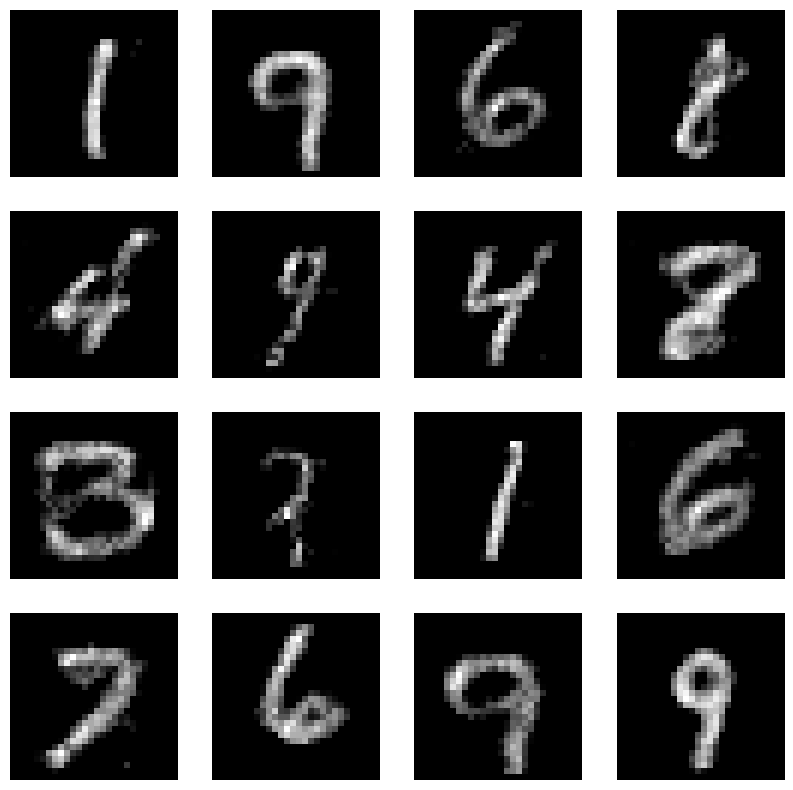

In [43]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()
for i in range(16):
    result_image = result[i].detach().cpu().reshape(-1, 28, 28)
    axes[i].imshow(result_image[0], cmap="gray")
    axes[i].axis("off")

## Visulizing custom loss output

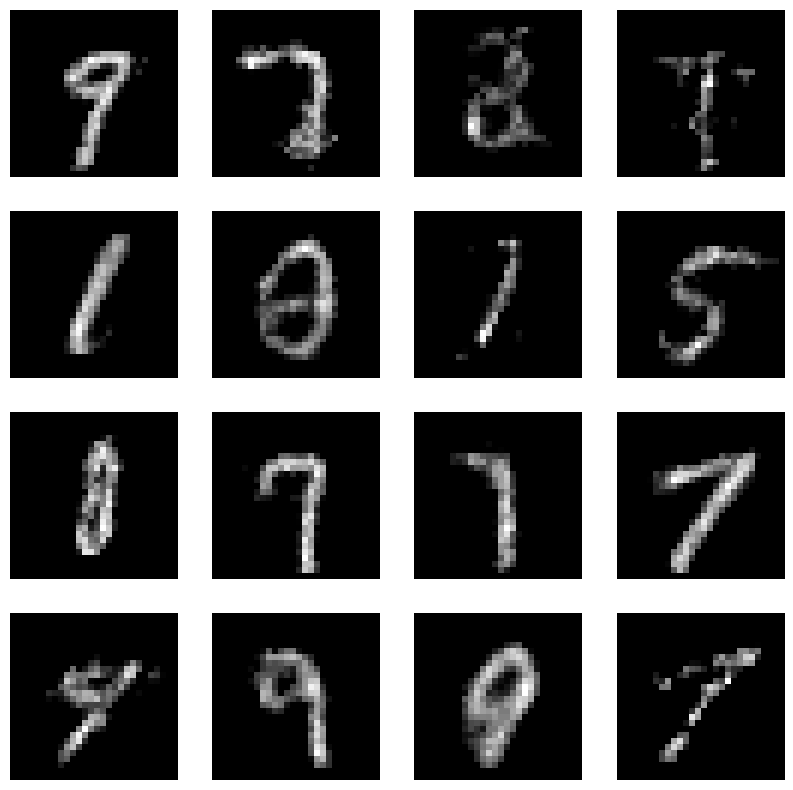

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()
for i in range(16):
    result_image = result[i].detach().cpu().reshape(-1, 28, 28)
    axes[i].imshow(result_image[0], cmap="gray")
    axes[i].axis("off")